In [ ]:
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta

fake = Faker()

def time_stamp_valid():
    base_date = fake.date_this_year()  # Generate a random date this year
    random_hour = np.random.randint(11, 22)  # Generate hour between 10 and 20 (inclusive)
    random_minute = np.random.randint(0, 60)  # Generate minute
    random_second = np.random.randint(0, 60)  # Generate second
    return datetime.combine(base_date, datetime.min.time()) + timedelta(
        hours=random_hour, minutes=random_minute, seconds=random_second
    )

def time_stamp_invalid():
    base_date = fake.date_this_year()  # Generate a random date this year
    if np.random.rand() < 0.5:
        random_hour = np.random.randint(0, 11)  # Hours between 0 and 10
    else:
        random_hour = np.random.randint(22, 24)  # Hours between 21 and 23
        
    random_minute = np.random.randint(0, 60)  # Generate minute
    random_second = np.random.randint(0, 60)  # Generate second
    return datetime.combine(base_date, datetime.min.time()) + timedelta(
        hours=random_hour, minutes=random_minute, seconds=random_second
    )

def normal_duration():
    return round(np.random.uniform(5, 15), 2)  # Normal durations between 5 and 15 seconds

# Function to generate suspicious duration times
def suspicious_duration():
    suspicious_patterns = [
        lambda: round(np.random.uniform(20, 30), 2),  # Unusually long durations
        lambda: round(np.random.uniform(1, 2), 2),   # Unusually short durations
        lambda: round(np.random.uniform(-10000, 0), 2) if np.random.rand() < 0.05 else normal_duration()  # Rare negative durations
    ]
    # Randomly select a pattern for suspicious duration
    return np.random.choice([pattern() for pattern in suspicious_patterns])

def item_code_frequent():
    return np.random.choice(['A123', 'B456', 'C789'], p = [0.526,0.316,0.158])

def item_code_rare():
    return 'D012'

def normal_amount():
    return round(np.random.uniform(5, 50), 2)

def suspicious_amount():
    suspicious_patterns = [
        lambda: 49.99 if np.random.rand() < 0.5 else 1.01,
        lambda: round(np.random.uniform(2000, 3000), 2) if np.random.rand() < 0.25 else normal_amount(),
        lambda: round(np.random.uniform(-10, -1), 2) if np.random.rand() < 0.05 else normal_amount()  # Rare negative values
    ]
    # Randomly select a pattern for the suspicious amount
    return np.random.choice([pattern() for pattern in suspicious_patterns])

def selector():
    if np.random.rand() < 0.05:  # Higher chance for anomalies
        time_stamp = np.random.choice([time_stamp_valid, time_stamp_invalid], p=[0.2, 0.8])()
        duration = np.random.choice([normal_duration, suspicious_duration], p=[0.05, 0.95])()
        item_code = np.random.choice([item_code_frequent, item_code_rare], p=[0.1, 0.9])()
        amount = np.random.choice([normal_amount, suspicious_amount], p=[0.05, 0.95])()
        is_anomalous = 1 if amount < 0 or duration < 0 else np.random.choice([1, 0], p=[0.99, 0.01])
    else:  # Normal case
        time_stamp = np.random.choice([time_stamp_valid, time_stamp_invalid], p=[0.95, 0.05])()
        duration = np.random.choice([normal_duration, suspicious_duration], p=[0.99, 0.01])()
        item_code = np.random.choice([item_code_frequent, item_code_rare], p=[0.9, 0.1])()
        amount = np.random.choice([normal_amount, suspicious_amount], p=[0.99, 0.01])()
        is_anomalous = 1 if amount < 0 or duration < 0 else np.random.choice([0, 1], p=[0.999, 0.001])
    
    return time_stamp, duration, item_code, amount, is_anomalous

# Generate synthetic POS logs
def generate_logs(num_logs=1000):
    logs = []
    for _ in range(num_logs):
        time_stamp, duration, item_code, amount, is_anomalous = selector()
        logs.append({
            'timestamp': time_stamp,
            'transaction_id': fake.uuid4(),  
            'duration_time': duration,
            'item_code': item_code,
            'amount': amount,
            'user_id': fake.uuid4(),  # Unique user ID
            'payment_method': np.random.choice(['credit_card', 'debit_card', 'cash'], p = [0.5, 0.15, 0.35]),  # Payment method
            'is_anomalous': is_anomalous
        })
    return pd.DataFrame(logs)

# Generate 50000 synthetic logs
logs_df = generate_logs(50000)

# Save to CSV
logs_df.to_csv('synthetic_pos_logs.csv', index=False)

print("Synthetic POS logs with duration saved to 'synthetic_pos_logs.csv'")


Synthetic POS logs with duration saved to 'synthetic_pos_logs.csv'


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("synthetic_pos_logs.csv")
# Convert timestamp to numeric formatl
le = LabelEncoder()
data['timestamp_numeric'] = pd.to_datetime(data['timestamp']).dt.hour  # Convert to Unix timestamp
data['payment_method'] = le.fit_transform(data['payment_method']) 
columns = data.columns
features = data[columns[:-2]]
features = features.drop(columns=['timestamp','transaction_id','user_id', 'payment_method']).join(data['timestamp_numeric'])
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoders = {}

# Map categorical columns to numeric values
for column in ['item_code']:  # List of categorical columns
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])
    label_encoders[column] = le  

print(features.head())

   duration_time  item_code  amount  timestamp_numeric
0           9.52          2   15.07                 12
1           7.12          0   34.19                 13
2           1.45          3    9.70                  9
3          13.86          0    6.65                 17
4           8.91          1   28.69                 14


In [17]:
print(data.head())

             timestamp                        transaction_id  duration_time  \
0  2024-03-13 12:28:48  cd8e5b93-7160-4beb-b99b-953a96b51b0b           9.52   
1  2024-03-03 13:42:32  cc375a30-8a50-4f88-b30d-0a4ee9c7522c           7.12   
2  2024-06-19 09:23:40  e12fe2fd-d503-4510-9a66-ee199e5b62cc           1.45   
3  2024-02-19 17:36:58  3e04fdc9-6923-4a2d-a35f-f6822aa3ffb8          13.86   
4  2024-02-05 14:06:03  b73bad90-b9e9-459e-9aa1-d90ce2b0580b           8.91   

  item_code  amount                               user_id  payment_method  \
0      C789   15.07  4f7a38b4-5660-42fe-8074-95baca322483               1   
1      A123   34.19  4cf91465-b6ea-4687-aaa8-e8108963707d               0   
2      D012    9.70  926c76ff-bf45-4f33-a8db-926c6faeb1cd               1   
3      A123    6.65  d68fd9ed-1564-4dbe-b87e-f4d0ecdcb1ec               0   
4      B456   28.69  e775aa07-1656-4e59-b083-99d4b651104f               0   

   is_anomalous  timestamp_numeric  
0             0          

In [18]:
print(data.shape)

(50000, 9)


In [6]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=50,algorithm='brute',p=np.inf,contamination = 0.1)
data['anomaly_predict'] = clf.fit_predict(features)

data['anomaly_predict'] = data['anomaly_predict'].map({-1: 1, 1: 0})

data['anomaly_predict'].value_counts()

anomaly_predict
0    45000
1     5000
Name: count, dtype: int64

In [23]:
from sklearn.ensemble import IsolationForest
# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100,
                            contamination=0.1,
                            max_samples=256,
                             bootstrap=True,
                            random_state=42)
iso_forest.fit(features)
data['anomaly_score'] = iso_forest.decision_function(features)
data['anomaly_predict'] = iso_forest.predict(features)
data['anomaly_predict'] = data['anomaly_predict'].map({-1: 1, 1: 0})

data['anomaly_predict'].value_counts()

anomaly_predict
0    45000
1     5000
Name: count, dtype: int64

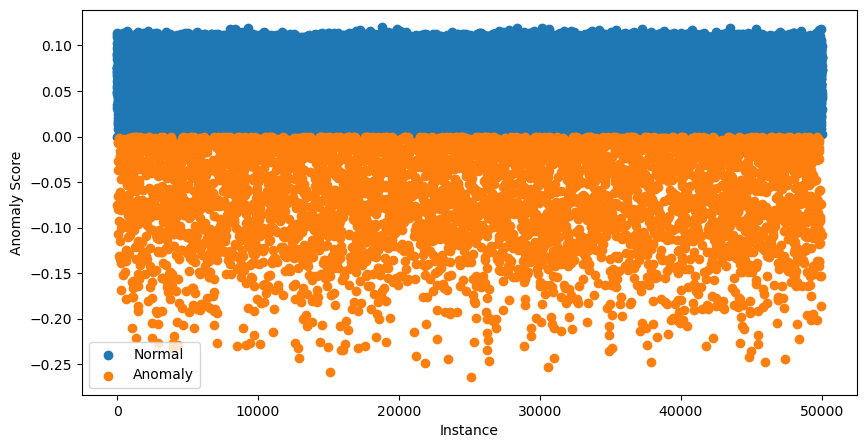

In [24]:
# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = data[data['anomaly_predict'] == 0]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = data[data['anomaly_predict'] == 1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

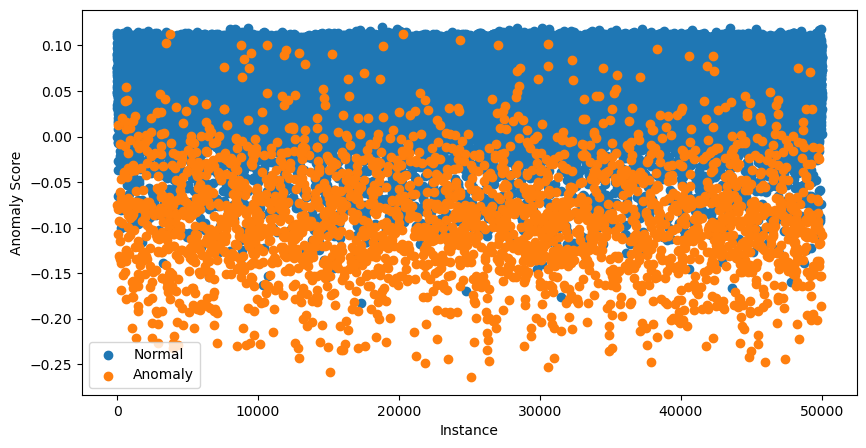

In [25]:
# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = data[data['is_anomalous'] == 0]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = data[data['is_anomalous'] == 1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix

y_true = data['is_anomalous']  # Ground truth
y_pred = data['anomaly_predict']  # Predicted values

# Compute confusion matrix
cm = confusion_matrix(y_pred, y_true)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[44811   189]
 [ 2626  2374]]
